### 数据预处理

In [10]:
# # 直接运行下载数据文件
# !wget -nc "http://labfile.oss.aliyuncs.com/courses/1081/MNIST_data.zip"
# !unzip -o "MNIST_data.zip"

--2020-02-13 19:54:08--  http://labfile.oss.aliyuncs.com/courses/1081/MNIST_data.zip
Resolving labfile.oss.aliyuncs.com (labfile.oss.aliyuncs.com)... 47.110.177.159
Connecting to labfile.oss.aliyuncs.com (labfile.oss.aliyuncs.com)|47.110.177.159|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11597468 (11M) [application/zip]
Saving to: ‘MNIST_data.zip’

MNIST_data.zip      100%[===================>]  11.06M  1.33MB/s    in 16s     

2020-02-13 19:54:25 (697 KB/s) - ‘MNIST_data.zip’ saved [11597468/11597468]

Archive:  MNIST_data.zip
   creating: MNIST_data/
 extracting: MNIST_data/t10k-labels-idx1-ubyte.gz  
 extracting: MNIST_data/train-labels-idx1-ubyte.gz  
  inflating: MNIST_data/t10k-images-idx3-ubyte.gz  
  inflating: MNIST_data/train-images-idx3-ubyte.gz  


In [11]:
# 此段数据读取代码无需掌握
import gzip
import numpy as np

def read_mnist(images_path, labels_path):
    with gzip.open("MNIST_data/" + labels_path, 'rb') as labelsFile:
        y = np.frombuffer(labelsFile.read(), dtype=np.uint8, offset=8)

    with gzip.open("MNIST_data/" + images_path, 'rb') as imagesFile:
        X = np.frombuffer(imagesFile.read(), dtype=np.uint8, offset=16) \
            .reshape(len(y), 784) \
            .reshape(len(y), 28, 28, 1)

    return X, y

train = {}
test = {}

train['X'], train['y'] = read_mnist(
    'train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz')
test['X'], test['y'] = read_mnist(
    't10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz')

train['X'].shape, train['y'].shape, test['X'].shape, test['y'].shape

((60000, 28, 28, 1), (60000,), (10000, 28, 28, 1), (10000,))

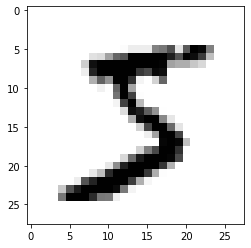

In [12]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.imshow(train['X'][0].reshape(28, 28), cmap=plt.cm.gray_r)

### 使用numpy创建独热编码  
np.eye(nb_classes)[targets]

In [15]:
# 样本 padding 填充
X_train = np.pad(train['X'], ((0, 0), (2, 2), (2, 2), (0, 0)), 'constant')
X_test = np.pad(test['X'], ((0, 0), (2, 2), (2, 2), (0, 0)), 'constant')
# 标签独热编码
y_train = np.eye(10)[train['y'].reshape(-1)]
y_test = np.eye(10)[test['y'].reshape(-1)]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 32, 32, 1), (10000, 32, 32, 1), (60000, 10), (10000, 10))

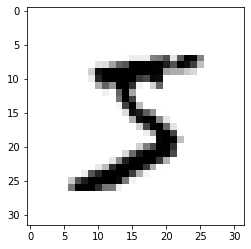

In [16]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.imshow(X_train[0].reshape(32, 32), cmap=plt.cm.gray_r)

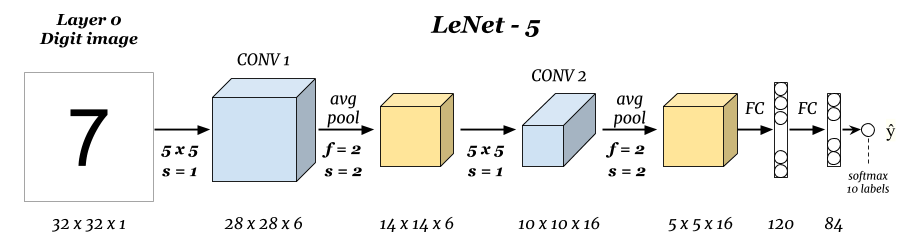

### PyTorch 低阶 `nn.Module` 构建

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 卷积层 1
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=(5, 5), stride=1)
        # 池化层 1
        self.pool1 = nn.AvgPool2d(kernel_size=(2, 2))
        # 卷积层 2
        self.conv2 = nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=(5, 5), stride=1)
        # 池化层 2
        self.pool2 = nn.AvgPool2d(kernel_size=(2, 2))
        # 全连接层
        self.fc1 = nn.Linear(in_features=5*5*16, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.reshape(-1, 5*5*16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x

In [4]:
model = LeNet()
model

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [17]:
model(torch.Tensor(X_train[0]).reshape(-1, 1, 32, 32))

tensor([[0.2768, 0.2464, 0.0068, 0.1361, 0.0141, 0.0084, 0.0105, 0.1877, 0.1079,
         0.0054]], grad_fn=<SoftmaxBackward>)

上面的示例中，`X_train[0]` 首先从 NumPy 数组转换为 PyTorch 张量，然后再被 `reshape` 为 `(-1, 1, 32, 32)`。其中，`-1` 是为了适应后面多个样本的数量，这也和我们先前使用 `-1` 的场景一致。`1` 表示一个通道，其与网络卷积层 `in_channels` 对应，后面的 `32` 当然是样本张量的尺寸。

最终，单个样本输出为 `torch.Size([1, 10])` 这也与我们预期的 Softmax 输出尺寸一致。

如今有了网络结构，接下来自然就是定义数据集并开始训练了。还记得前面介绍过的 PyTorch 中的 `DataLoader` 吗？其可以使我们很方便地读取小批量数据。如今，我们也可以将自定义的 NumPy 数组转换为 `DataLoader` 加载器。

In [18]:
import torch.utils.data

# 依次传入样本和标签张量，制作训练数据集和测试数据集
train_data = torch.utils.data.TensorDataset(torch.Tensor(
    X_train), torch.Tensor(train['y']))
test_data = torch.utils.data.TensorDataset(torch.Tensor(
    X_test), torch.Tensor(test['y']))

train_data, test_data

(<torch.utils.data.dataset.TensorDataset at 0x1038c30d0>,
 <torch.utils.data.dataset.TensorDataset at 0x119f8d310>)

上面的代码中，样本传入了由 `X_train` 和 `X_test` 转换后的 PyTorch 张量。标签则传入了未被独热编码前的 `train['y']` 和 `test['y']`，而不是上面 TensorFlow 使用的独热编码后的 `y_train` 或 `y_test`。原因在于，PyTorch 的损失函数无需标签为独热编码的形式，原本的数值标签即可处理。


然后，我们使用 `DataLoader` 数据加载器来加载数据集，设定好 `batch_size`。一般，训练数据会被打乱，而测试数据无需打乱。

In [19]:
train_loader = torch.utils.data.DataLoader(dataset= train_data, batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset= test_data, batch_size=64,shuffle=False)

train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x1038b5e50>,
 <torch.utils.data.dataloader.DataLoader at 0x1038b5e10>)

In [20]:
loss_fn = nn.CrossEntropyLoss()  # 交叉熵损失函数
opt = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam 优化器

最后，定义训练函数。这里直接将前面的代码拿过来使用，只需要注意 `images` 需要被 `reshape` 为 `(-1, 1, 32, 32)` 的形状。而 `labels` 需要被转换为 `torch.LongTensor` 类型防止报错。

In [21]:
def fit(epochs, model, opt):
    # 全数据集迭代 epochs 次
    print('=============== Start Training ================')
    for epoch in range(epochs):
        # 从数据加载器中读取 Batch 数据开始训练
        for i, (images, labels) in enumerate(train_loader):

            images = images.reshape(-1, 1, 32, 32)  # 对特征数据展平，变成 784
            labels = labels.type(torch.LongTensor)  # 真实标签

            outputs = model(images)  # 前向传播
            loss = loss_fn(outputs, labels)  # 传入模型输出和真实标签

            opt.zero_grad()  # 优化器梯度清零，否则会累计
            loss.backward()  # 从最后 loss 开始反向传播
            opt.step()  # 优化器迭代

            # 自定义训练输出样式
            if (i+1) % 100 == 0:
                print('Epoch [{}/{}], Batch [{}/{}], Train loss: {:.3f}'
                      .format(epoch+1, epochs, i+1, len(train_loader), loss.item()))

        # 每个 Epoch 执行一次测试
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.reshape(-1, 1, 32, 32)
            labels = labels.type(torch.LongTensor)

            outputs = model(images)
            # 得到输出最大值 _ 及其索引 predicted
            _, predicted = torch.max(outputs.data, 1)

            correct += (predicted == labels).sum().item()  # 如果预测结果和真实值相等则计数 +1
            total += labels.size(0)  # 总测试样本数据计数

        print('============ Test accuracy: {:.3f} ============='.format(
            correct / total))

In [22]:
fit(epochs=2, model=model, opt=opt)

=============== Start Training ================
Epoch [1/2], Batch [100/938], Train loss: 1.713
Epoch [1/2], Batch [200/938], Train loss: 1.626
Epoch [1/2], Batch [300/938], Train loss: 1.467
Epoch [1/2], Batch [400/938], Train loss: 1.513
Epoch [1/2], Batch [500/938], Train loss: 1.541
Epoch [1/2], Batch [600/938], Train loss: 1.493
Epoch [1/2], Batch [700/938], Train loss: 1.493
Epoch [1/2], Batch [800/938], Train loss: 1.508
Epoch [1/2], Batch [900/938], Train loss: 1.530
============ Test accuracy: 0.968 =============
Epoch [2/2], Batch [100/938], Train loss: 1.462
Epoch [2/2], Batch [200/938], Train loss: 1.478
Epoch [2/2], Batch [300/938], Train loss: 1.492
Epoch [2/2], Batch [400/938], Train loss: 1.477
Epoch [2/2], Batch [500/938], Train loss: 1.463
Epoch [2/2], Batch [600/938], Train loss: 1.529
Epoch [2/2], Batch [700/938], Train loss: 1.461
Epoch [2/2], Batch [800/938], Train loss: 1.486
Epoch [2/2], Batch [900/938], Train loss: 1.508
============ Test accuracy: 0.974 ======

### PyTorch 高阶 `nn.Sequential` 构建

In [23]:
class Flatten(nn.Module):
    def forward(self,input):
        return input.reshape(input.size(0), -1)

# 构建 Sequential 容器结构
model_s = nn.Sequential(
    nn.Conv2d(1, 6, (5, 5), 1),
    nn.ReLU(),
    nn.AvgPool2d((2, 2)),
    nn.Conv2d(6, 16, (5, 5), 1),
    nn.ReLU(),
    nn.AvgPool2d((2, 2)),
    Flatten(),
    nn.Linear(5*5*16, 120),
    nn.ReLU(),
    nn.Linear(120, 84),
    nn.ReLU(),
    nn.Linear(84, 10),
    nn.Softmax(dim=1)
)

model_s

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (6): Flatten()
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): ReLU()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): ReLU()
  (11): Linear(in_features=84, out_features=10, bias=True)
  (12): Softmax(dim=1)
)

In [24]:
opt_s = torch.optim.Adam(model_s.parameters(), lr=0.001)  # Adam 优化器
fit(epochs=2, model=model_s, opt=opt_s)

=============== Start Training ================
Epoch [1/2], Batch [100/938], Train loss: 1.583
Epoch [1/2], Batch [200/938], Train loss: 1.556
Epoch [1/2], Batch [300/938], Train loss: 1.565
Epoch [1/2], Batch [400/938], Train loss: 1.601
Epoch [1/2], Batch [500/938], Train loss: 1.616
Epoch [1/2], Batch [600/938], Train loss: 1.645
Epoch [1/2], Batch [700/938], Train loss: 1.516
Epoch [1/2], Batch [800/938], Train loss: 1.494
Epoch [1/2], Batch [900/938], Train loss: 1.504
============ Test accuracy: 0.974 =============
Epoch [2/2], Batch [100/938], Train loss: 1.477
Epoch [2/2], Batch [200/938], Train loss: 1.508
Epoch [2/2], Batch [300/938], Train loss: 1.492
Epoch [2/2], Batch [400/938], Train loss: 1.481
Epoch [2/2], Batch [500/938], Train loss: 1.523
Epoch [2/2], Batch [600/938], Train loss: 1.480
Epoch [2/2], Batch [700/938], Train loss: 1.488
Epoch [2/2], Batch [800/938], Train loss: 1.498
Epoch [2/2], Batch [900/938], Train loss: 1.462
============ Test accuracy: 0.974 ======